In [ ]:
!nvidia-smi

In [1]:
from __future__ import print_function
import keras
from keras import metrics
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

import tensorflow as tf
# 自動增長 GPU 記憶體用量
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 Session
tf.keras.backend.set_session(sess)


Using TensorFlow backend.


In [2]:
import os
class_name = 'Class10'
img_base_path = '/home/z99792458/nbs/Dataset/img_defects/hci_defect_datasets/'
class1_path = os.path.join(img_base_path, class_name)
class1_train_path = os.path.join(class1_path, 'Train')
class1_test_path = os.path.join(class1_path, 'Test')
labeled_img = [x[:4] for x in os.listdir(os.path.join(class1_train_path, 'Label'))] + [x[:4] for x in os.listdir(os.path.join(class1_test_path, 'Label'))]
labeled_img = list(set(labeled_img))
all_img = [x for x in os.listdir(class1_train_path) if x.find('_256') >-1] + [x for x in os.listdir(class1_test_path) if x.find('_256') >-1]
normal_img_name = [x for x in all_img if x[:4] not in labeled_img]
defect_img_name = [x for x in all_img if x[:4] in labeled_img]
train_img_names, test_img_names = train_test_split(normal_img_name, test_size=0.25)

train_imgs = list()
test_imgs = list()
for img_name in os.listdir(class1_train_path):
    if (img_name in train_img_names) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_train_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            train_imgs.append(img)
    if (img_name in test_img_names) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_train_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            test_imgs.append(img)

for img_name in os.listdir(class1_test_path):
    if (img_name in train_img_names) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_test_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            train_imgs.append(img)
    if (img_name in test_img_names) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_test_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            test_imgs.append(img)

train_imgs = (np.stack(train_imgs)).astype(float)/255
test_imgs = (np.stack(test_imgs)).astype(float)/255

img_shape = train_imgs.shape[1:]

In [3]:
# Get defected images
defect_imgs = list()
for img_name in os.listdir(class1_train_path):
    if (img_name in defect_img_name) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_train_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            defect_imgs.append(img)
for img_name in os.listdir(class1_test_path):
    if (img_name in defect_img_name) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_train_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            defect_imgs.append(img)
defect_imgs = (np.stack(defect_imgs)).astype(float)/255
# defect_imgs = defect_imgs.reshape(defect_imgs.shape[0], -1)

In [4]:
train_imgs.shape 

(1500, 256, 256, 1)

/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 1500 + 1) instead
  


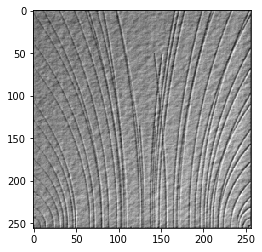

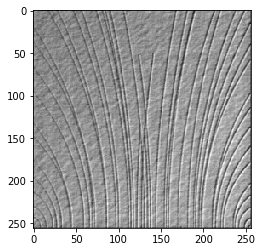

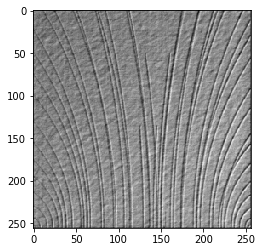

/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 150 + 1) instead
  del sys.path[0]


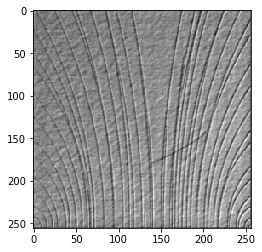

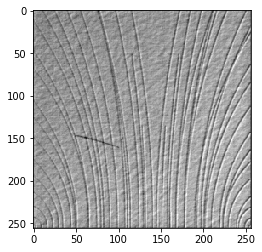

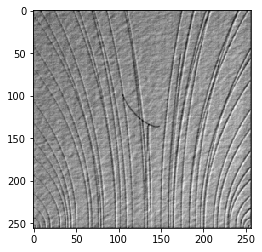

<Figure size 432x288 with 0 Axes>

In [6]:
# Randomly select n normal images
n = 3 # how many digits we will display

# plt.figure(figsize=(3, 2))
index = 0
for i in np.random.random_integers(0, train_imgs.shape[0], n):
    # display original
    plt.imshow(train_imgs[i].reshape(train_imgs.shape[1:3]))
    plt.show()
    plt.gray()

index = 0
for i in np.random.random_integers(0, defect_imgs.shape[0], n):
    plt.imshow(defect_imgs[i].reshape(defect_imgs.shape[1:3]))
    plt.show()
    plt.gray()
    index += 1

In [7]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1.e-3
    if epoch > 20000:
        lr *= 1.e-2
    elif epoch > 10000:
        lr *= 1e-1
    elif epoch > 2000:
        lr *= 1.e-1
    elif epoch > 500:
        lr *= 1.0e-1
    print('Learning rate: ', lr)
    return lr


In [8]:
train_imgs.shape[1:]

(256, 256, 1)

In [9]:
input_img = Input(shape=train_imgs.shape[1:])  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=[2,2])(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=[2,2])(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same', strides=[2,2])(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
autoencoder.compile(optimizer=Adam(lr=lr_schedule(0)), loss='mse', metrics=[metrics.mae])
autoencoder.summary()

Learning rate:  0.001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)      

In [11]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [12]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
import datetime as dt
model_name_prefix = 'conv_autoencoder_' + class_name + '_with_stride_%s' % ( dt.datetime.now().strftime("%Y%m%d%H"))
model_name = model_name_prefix + '_{epoch:03d}.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

In [13]:
callbacks = [lr_reducer, lr_scheduler]
# callbacks = []

In [ ]:
# Run training
history = autoencoder.fit(train_imgs, train_imgs,
          batch_size=16,
          epochs=10000,
          validation_data=(test_imgs, test_imgs),
          shuffle=True,
          callbacks=callbacks)

In [ ]:
autoencoder.save_weights("./saved_models/" + model_name_prefix + "_final_models.h5") 

In [14]:
# autoencoder.load_weights("./saved_models/conv_autoencoder_class10_with_stride_2019102120_final_models.h5") 

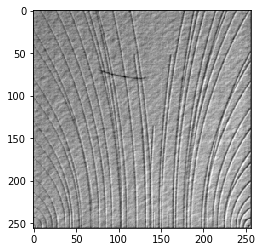

In [19]:
img = defect_imgs[20]
plt.imshow(img.reshape((256, 256)))

In [20]:
predicted = autoencoder.predict(defect_imgs)

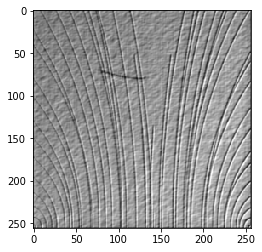

In [21]:
plt.imshow(predicted[20].reshape((256,256)))

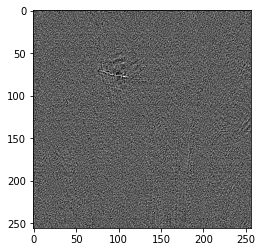

In [22]:
plt.imshow(predicted[20].reshape((256,256)) - img.reshape((256, 256)))